In [60]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from src.model.generator.unet import Unet
from torchvision import transforms

from utils import set_random_seed

import tqdm
from tqdm import tqdm
from IPython.display import clear_output
import sys
import matplotlib.pyplot as plt
import numpy as np

In [61]:
RANDOM_STATE = 322
LEARN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

set_random_seed(RANDOM_STATE)

In [62]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
val_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
grayscale = transforms.Grayscale(1)

train_dataset = ImageFolder("./data/dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("./data/dataset/dataset/val", transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=LEARN_BATCH_SIZE, shuffle=True,  num_workers=7)
val_dataloader = DataLoader(val_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=7)

In [63]:
def train_epoch(model, optim, criterion, train_loader):
    model.train()
    losses = []
    with tqdm(total=len(train_loader)) as prbar:
        for imgs, _ in train_loader:
            imgs_bw = grayscale(imgs)
            imgs = imgs.to(DEVICE)
            imgs_bw = imgs_bw.to(DEVICE)
            pred_imgs = model(imgs_bw)
            loss = criterion(pred_imgs, imgs)
            loss.backward()
            optim.step()
            optim.zero_grad()
            prbar.set_description(
              f"Loss: {loss.item()} "
            )
            prbar.update(1)
            losses.append(loss.item())
    return np.mean(losses)

def train(model, optim, criterion, train_loader, val_loader, epoches=6):
    model.to(DEVICE)
    train_losses = []
    for epoch in range(epoches):
        epoch_loss = train_epoch(model, optim, criterion, train_loader)
        train_losses.append(epoch_loss)
        clear_output()
        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(len(train_losses)), train_losses, c="C1", label="train_loss")
        plt.show()

In [64]:
model = Unet(5, 1, 512, 3, 64).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = torch.nn.L1Loss()

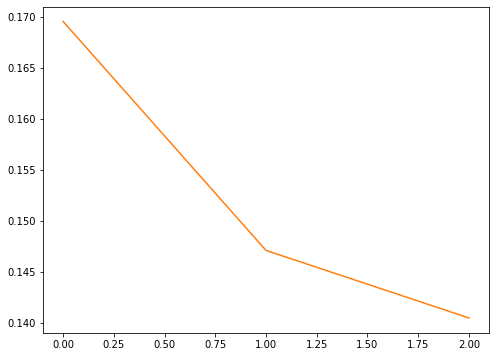

Loss: 0.13132017850875854 :  11%|█▏        | 2866/25000 [01:06<08:28, 43.55it/s]

In [ ]:
train(model, optimizer, criterion, train_dataloader, val_dataloader)

In [36]:
@torch.inference_mode()
def eval(model, val_dataset, ids=None):
    preds = []
    targets = []
    bw = []
    if ids is None:
        ids = torch.randint(len(val_dataset), size=(5,))
    for idx in ids:
        img, _ = val_dataset[idx]
        img_bw = grayscale(img).to(DEVICE).unsqueeze(0)
        pred_img = model(img_bw)
        preds.append(pred_img)
        targets.append(img)
        bw.append(img_bw.cpu())
    return preds, targets, bw

tensor([2161, 8875, 8428, 9799, 1651])


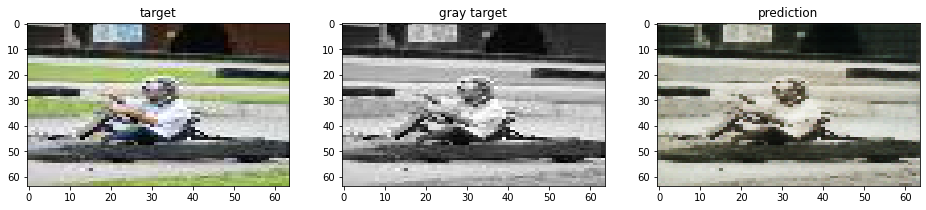

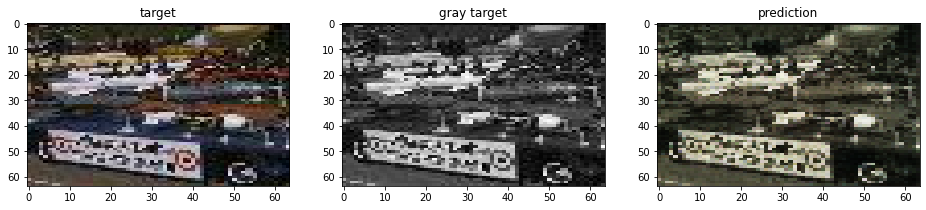

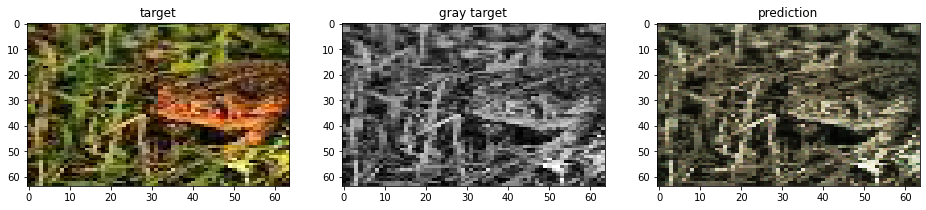

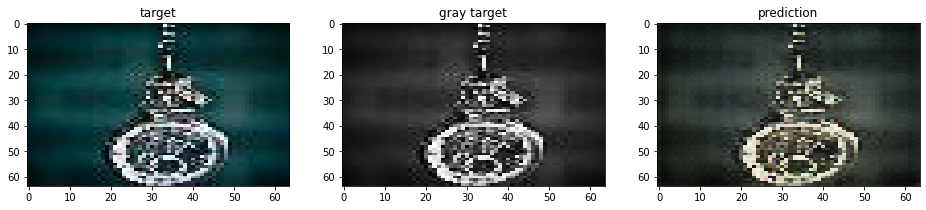

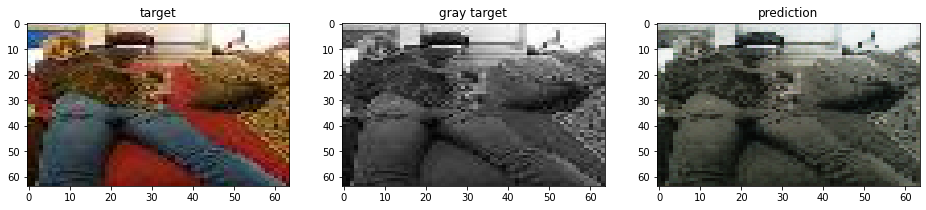

In [52]:
p, t, bw = eval(model, val_dataset)

for row in range(len(p)):
    plt.figure(figsize = (16,3))
    p0 = p[row].cpu().numpy().squeeze().transpose(1, 2, 0)
    p0 = p0 * 0.5 + 0.5
    t0 = t[row].cpu().numpy().squeeze().transpose(1, 2, 0)
    t0 = t0 * 0.5 + 0.5
    bw0 = bw[row].cpu().numpy().squeeze()
    bw0 = bw0 * 0.5 + 0.5
    
    plt.subplot(1, 3, 1)
    plt.title("target")
    plt.imshow(t0, interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 2)
    plt.title("gray target")
    plt.imshow(bw0, cmap="gray", interpolation='nearest', aspect='auto')
    plt.subplot(1, 3, 3)
    plt.title("prediction")
    plt.imshow(p0, interpolation='nearest', aspect='auto')
    plt.show()

In [20]:
grayscale(val_dataset[956][0]).to(DEVICE)

torch.Size([1, 64, 64])

In [29]:
((t[0].squeeze() * 0.5) + 0.5)

tensor(0.)